In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import seaborn as sns
import random
import os

# Define functions for analysis

In [2]:
def optimal_k (kmodes_dict, unique_ages):
    for elem in unique_ages:
        print("Test for ", elem)
        cost = []
        K = range(1,7)
        for num_clusters in list(K):
            kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 4, verbose=0)
            kmode.fit_predict(kmodes_dict[elem])
            cost.append(kmode.cost_)

        plt.plot(K, cost, 'bx-')
        plt.xlabel('No. of clusters')
        plt.ylabel('Cost')
        plt.title('Elbow Method For Optimal k')
        plt.show()

In [3]:
def find_clusters(kmodes_dict, unique_age, n):

    df = kmodes_dict[unique_age]

    kmode = KModes(n_clusters=n, init = 'Cao', n_init = 10, verbose=0)
    clusters = kmode.fit_predict(df)
    print(kmode.cluster_centroids_)
    
    df.insert(0, "Cluster", clusters, True) 
    df['Cluster'] = df['Cluster'] + 1
    
    return df

In [4]:
def pie_chart_plots(df, n_clusters, thresh, column_names, colors_dict, foldername):
    curr = os.getcwd()
    path = curr + '\\' + foldername + '\\'
    if not os.path.isdir(path):
        os.makedirs(path)
    i = 0
    
    for elem in colors_dict:
        
        fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5))

        print("n1 = ", len(df[df['Cluster'] == 1]), ", n2 = ", 
              len(df[df['Cluster'] == 2]), ", n3 = ", len(df[df['Cluster'] == 3]))
        print("p1 = ", round((len(df[df['Cluster'] == 1])/len(df)), 3), ", p2 = ", 
              round((len(df[df['Cluster'] == 2])/len(df)), 3), ", p3 = ", round((len(df[df['Cluster'] == 3])/len(df)), 3))
        
        for k in range(n_clusters):
            k+=1

            cluster = df[df.Cluster == k]
            counts = pd.Series(cluster[column_names[i]]).value_counts()
            counts = counts / sum (counts)
            a = counts[counts > thresh]
            a['other'] = counts[counts <= thresh].sum()

            axes[k-1].pie(a, labels = a.index, colors=[colors_dict[i][v] for v in a.keys()])
            axes[k-1].set_title('Cluster ' + str(k))
        
        fig.suptitle("Plots for Ages " + df['age_bin'][1])
        plt.savefig(fname  = (path + 'Plots for Ages ' + df['age_bin'][1] + '.png'))
        plt.show()
        
        i+=1

In [5]:
def create_color_assignments(cat_list, df_kmodes):
    dict_list = []
    
    for elem in cat_list:
        val_list = (df_kmodes[elem].unique()).tolist()
        num_colors = len(val_list)
        colors = ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
             for j in range(num_colors)]
        dict_val = dict(zip(val_list, colors))
        dict_val.update({'other':'#990000'})
        dict_list.append(dict_val)
        
    return(dict_list)

# Load and filter data

This notebook only demonstrates 50% of the data, though 100% can also be run (ran out of time to merge)

In [6]:
#read csv files and store them as pandas dataframes

raw_articles_df = pd.read_csv ('articles.csv')
raw_train_df = pd.read_csv ('transactions_train.csv')
raw_customers_df = pd.read_csv ('customers.csv')

In [7]:
#take sample of transaction data (50% of 32 million individual transactions)
#make sure datetime format is used for transaction dates

df_sample = raw_train_df.sample(frac=.5, replace=True, random_state=1)
pd.to_datetime(df_sample['t_dat']) 

12710949   2019-06-26
21463275   2020-01-20
6762380    2019-02-27
12325960   2019-06-22
491263     2018-09-29
              ...    
7460721    2019-03-16
20009478   2019-12-10
26458225   2020-05-28
28917424   2020-07-12
592749     2018-09-30
Name: t_dat, Length: 15894162, dtype: datetime64[ns]

In [8]:
#add categorical data to transactions sample dataframe (code can be simplified)

id_type_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.product_type_name))
id_color_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.colour_group_name))
id_patt_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.graphical_appearance_name))
id_age_dict = dict(zip(raw_customers_df.customer_id, raw_customers_df.age))

df_sample['product_type'] = df_sample['article_id'].map(id_type_dict)
df_sample['color'] = df_sample['article_id'].map(id_color_dict)
df_sample['pattern'] = df_sample['article_id'].map(id_patt_dict)
df_sample['age'] = df_sample['customer_id'].map(id_age_dict)

#df_sample

In [9]:
#extract the month from the date
#create age bins
#get rid of columns we won't use for now (price, sales channel, article id, date )
#month is created because it was sometimes used in analysis

df_kmodes = df_sample.set_index('customer_id')
df_kmodes['month'] = pd.DatetimeIndex(df_kmodes['t_dat']).month
df_kmodes['age_bin'] = pd.cut(df_kmodes['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])

#winter is 12/1/2, spring 3/4/5, etc
df_kmodes = df_kmodes.replace(12,1)
df_kmodes['season'] = pd.cut(df_kmodes['month'], [0, 2, 5, 8, 11], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'])


df_kmodes = df_kmodes.drop(['price', 'sales_channel_id', 'article_id', 't_dat', 'age', 'month'], axis = 1)
df_kmodes.head()

product_type  \
customer_id                                                           
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...         Vest top   
3e42e97cfc1cc859829830b9ef6f594e48e1441b7771891...  Leggings/Tights   
7afdec03c17e8d471db4641cde7c92f62a2338304779d87...          Sweater   
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...            Dress   
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...          T-shirt   

                                                              color  \
customer_id                                                           
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...           Orange   
3e42e97cfc1cc859829830b9ef6f594e48e1441b7771891...            Black   
7afdec03c17e8d471db4641cde7c92f62a2338304779d87...        Dark Blue   
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...  Yellowish Brown   
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...              Red   

                                                             pattern age_bin  \
customer_id                                                                    
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...             Solid   20-30   
3e42e97cfc1cc859829830b9ef6f594e48e1441b7771891...             Solid   50-60   
7afdec03c17e8d471db4641cde7c92f62a2338304779d87...            Stripe    0-20   
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...  All over pattern   70-80   
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...             Solid   20-30   

                                                    season  
customer_id                                                 
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...  Summer  
3e42e97cfc1cc859829830b9ef6f594e48e1441b7771891...  Winter  
7afdec03c17e8d471db4641cde7c92f62a2338304779d87...  Winter  
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...  Summer  
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...    Fall

In [10]:
#get rid of the most common items (also items that don't change much seasonally/fashionably) as determined by previous analysis
#get rid of things barely purchased

df_kmodes2 = df_kmodes[df_kmodes.color != 'Black' ]
df_kmodes2 = df_kmodes2[df_kmodes2.color != 'White' ]
df_kmodes2 = df_kmodes2[df_kmodes2.color != 'Dark Blue' ]

df_kmodes2 = df_kmodes2[df_kmodes2.product_type != 'Trousers' ]

df_kmodes2 = df_kmodes2[df_kmodes2.groupby('product_type').product_type.transform(len) > 1000]
df_kmodes2 = df_kmodes2.dropna()

df_kmodes2.head()

product_type  \
customer_id                                                       
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...     Vest top   
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...        Dress   
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...      T-shirt   
9c8761fcb2106e9664601a1cd87b79bc99b9049b0dbe787...      T-shirt   
78971a184035137737aecedfce711be93b6a603161d908a...     Cardigan   

                                                              color  \
customer_id                                                           
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...           Orange   
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...  Yellowish Brown   
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...              Red   
9c8761fcb2106e9664601a1cd87b79bc99b9049b0dbe787...            Beige   
78971a184035137737aecedfce711be93b6a603161d908a...      Light Beige   

                                                             pattern age_bin  \
customer_id                                                                    
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...             Solid   20-30   
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...  All over pattern   70-80   
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...             Solid   20-30   
9c8761fcb2106e9664601a1cd87b79bc99b9049b0dbe787...   Colour blocking   30-40   
78971a184035137737aecedfce711be93b6a603161d908a...             Solid   50-60   

                                                    season  
customer_id                                                 
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa...  Summer  
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4d...  Summer  
88beadfe55a64381384b9c83334e3bb13be26374873b0dc...    Fall  
9c8761fcb2106e9664601a1cd87b79bc99b9049b0dbe787...  Summer  
78971a184035137737aecedfce711be93b6a603161d908a...  Spring

In [11]:
#Create dictionary of dataframes for cluster optimization

#create unique list of ages
unique_ages = df_kmodes2.age_bin.unique()

#create a data frame dictionary to store df
kmodes_dict = {elem : pd.DataFrame() for elem in unique_ages}

for key in kmodes_dict.keys():
    kmodes_dict[key] = df_kmodes2[:][df_kmodes2.age_bin == key]
    
#access with kmodes_dict['key']

Test for  20-30


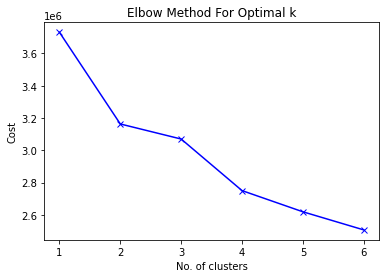

Test for  70-80


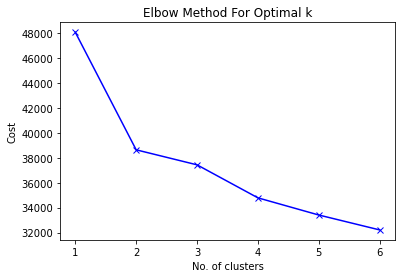

Test for  30-40


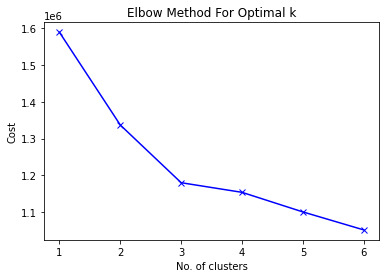

Test for  50-60


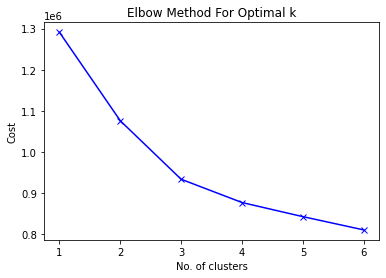

Test for  60-70


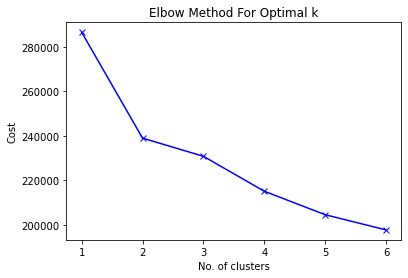

Test for  40-50


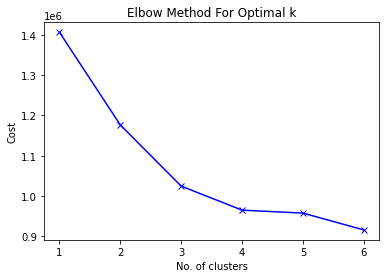

Test for  0-20


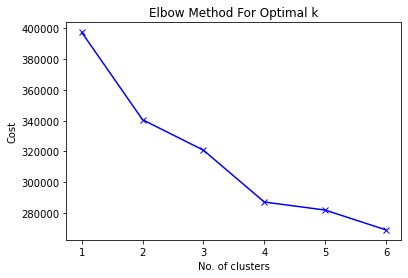

Test for  80-90


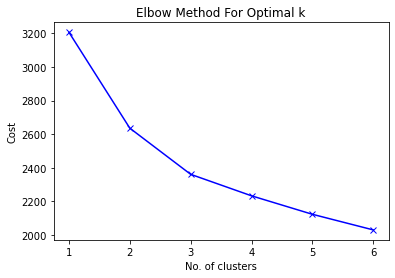

Test for  90-100


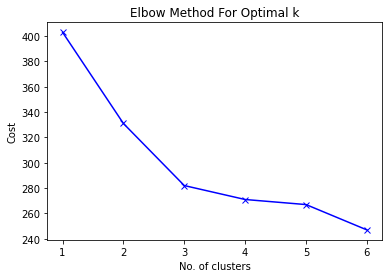

In [272]:
optimal_k (kmodes_dict, unique_ages)

In [12]:
#while a small portion of clusters show an elbow at k = 2 or k = 4, most show one at k = 3
#so, for the sake of continuity in the analysis, we will use k = n = 3

#also prints centers of clusters

n = 3

df_20 = find_clusters(kmodes_dict, unique_ages[0], n)
df_70 = find_clusters(kmodes_dict, unique_ages[1], n)
df_30 = find_clusters(kmodes_dict, unique_ages[2], n)
df_50 = find_clusters(kmodes_dict, unique_ages[3], n)
df_60 = find_clusters(kmodes_dict, unique_ages[4], n)
df_40 = find_clusters(kmodes_dict, unique_ages[5], n)
df_0 = find_clusters(kmodes_dict, unique_ages[6], n)
df_80 = find_clusters(kmodes_dict, unique_ages[7], n)
df_90 = find_clusters(kmodes_dict, unique_ages[8], n)

[['Sweater' 'Light Beige' 'Solid' '20-30' 'Summer']
 ['Dress' 'Beige' 'All over pattern' '20-30' 'Spring']
 ['Sweater' 'Grey' 'Melange' '20-30' 'Fall']]
[['Sweater' 'Light Beige' 'Solid' '70-80' 'Fall']
 ['Dress' 'Beige' 'All over pattern' '70-80' 'Spring']
 ['T-shirt' 'Off White' 'Melange' '70-80' 'Summer']]
[['Sweater' 'Light Beige' 'Solid' '30-40' 'Summer']
 ['Dress' 'Light Pink' 'All over pattern' '30-40' 'Spring']
 ['Sweater' 'Grey' 'Melange' '30-40' 'Fall']]
[['Sweater' 'Light Beige' 'Solid' '50-60' 'Summer']
 ['Dress' 'Beige' 'All over pattern' '50-60' 'Spring']
 ['Sweater' 'Grey' 'Melange' '50-60' 'Fall']]
[['Sweater' 'Light Beige' 'Solid' '60-70' 'Summer']
 ['Dress' 'Beige' 'All over pattern' '60-70' 'Fall']
 ['Blouse' 'Off White' 'Melange' '60-70' 'Spring']]
[['Sweater' 'Light Beige' 'Solid' '40-50' 'Summer']
 ['Dress' 'Grey' 'All over pattern' '40-50' 'Spring']
 ['Sweater' 'Light Pink' 'Melange' '40-50' 'Fall']]
[['Sweater' 'Red' 'Solid' '0-20' 'Summer']
 ['T-shirt' 'Light B

In [23]:
df_list = [df_20, df_70, df_30, df_50, df_60, df_40, df_0, df_80,df_90]
cat_list = ['product_type', 'pattern', 'color', 'season']

In [24]:
dict_list = create_color_assignments(cat_list = cat_list, df_kmodes = df_kmodes2)

In [48]:
#example
#pie_chart_plots(df = df_30, n_clusters=3, thresh=0.03, column_names = cat_list, colors_dict=dict_list, foldername = 'test')

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


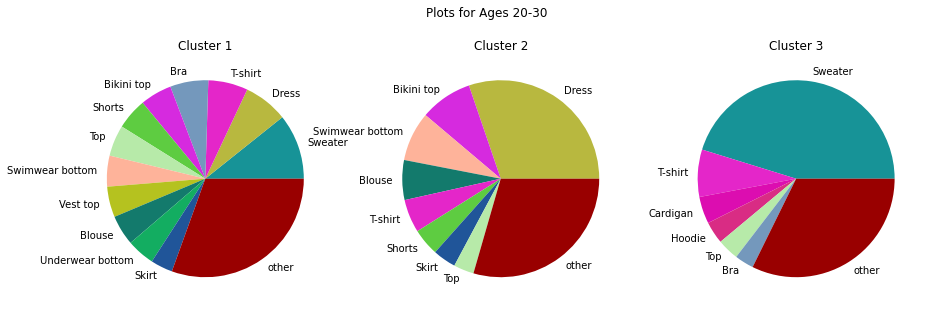

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


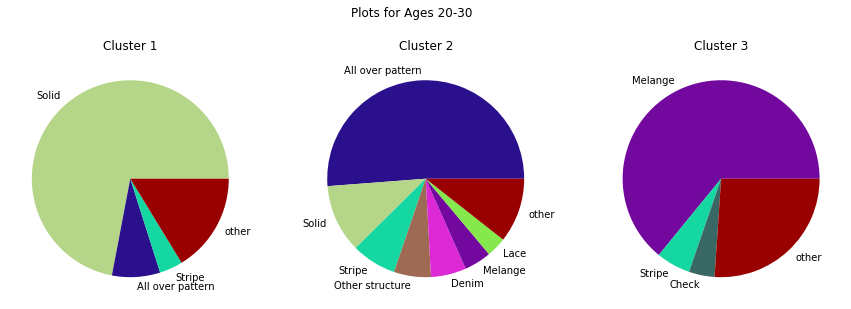

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


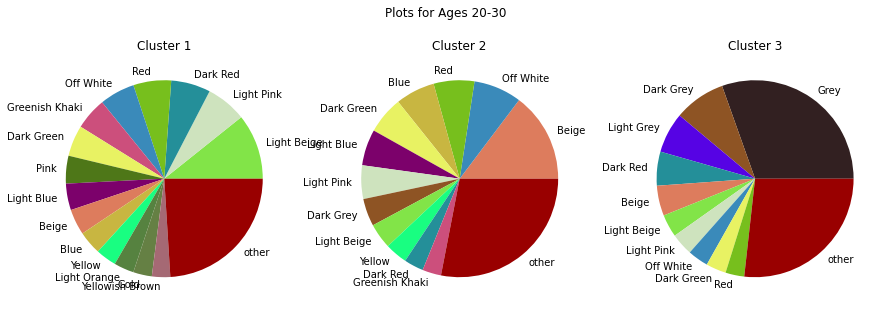

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


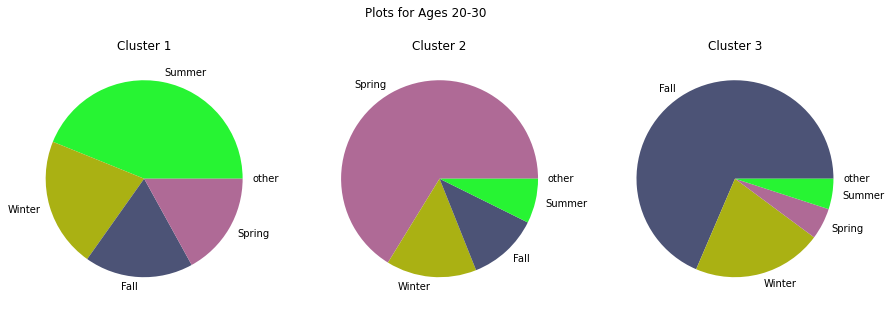

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


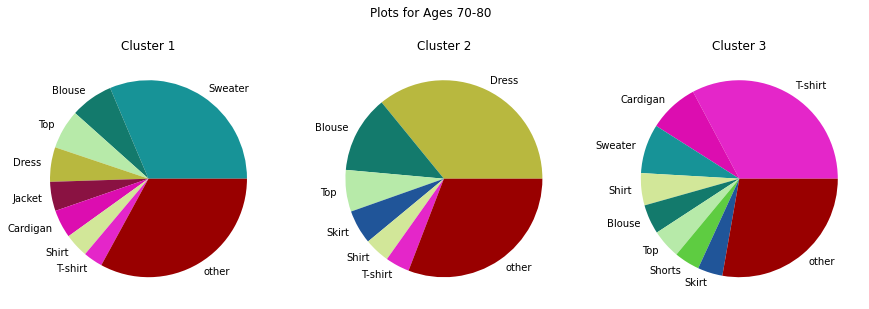

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


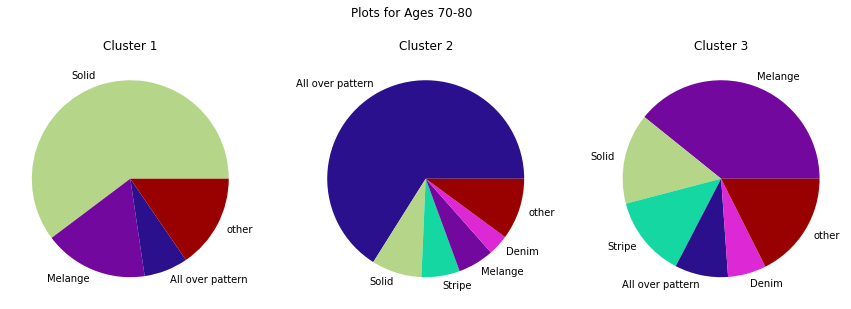

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


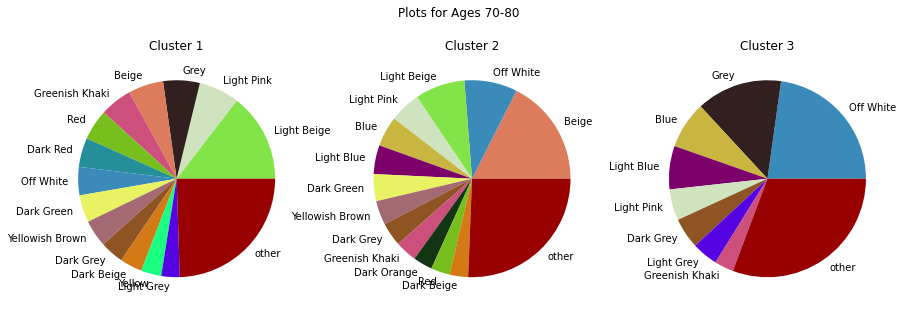

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


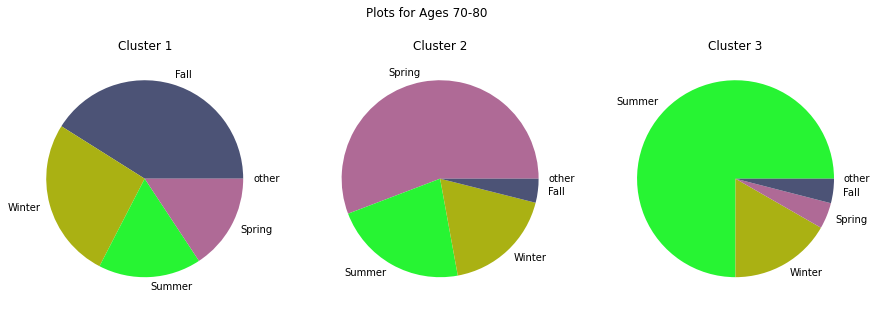

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


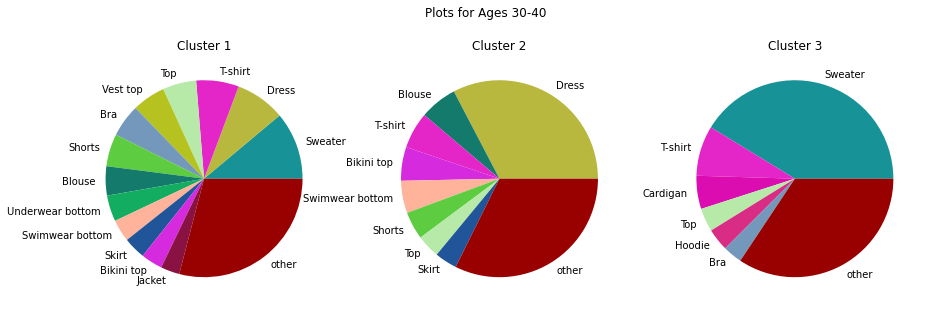

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


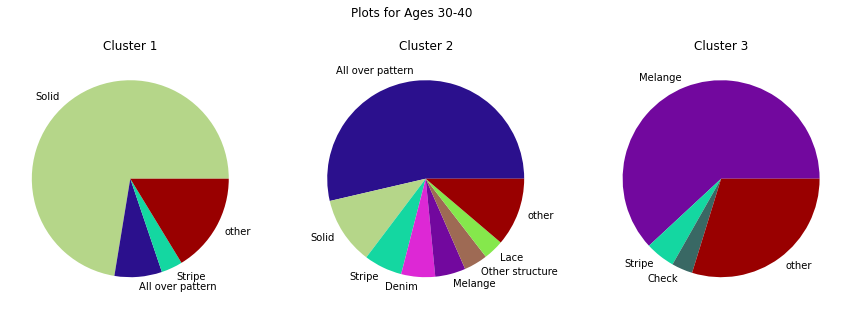

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


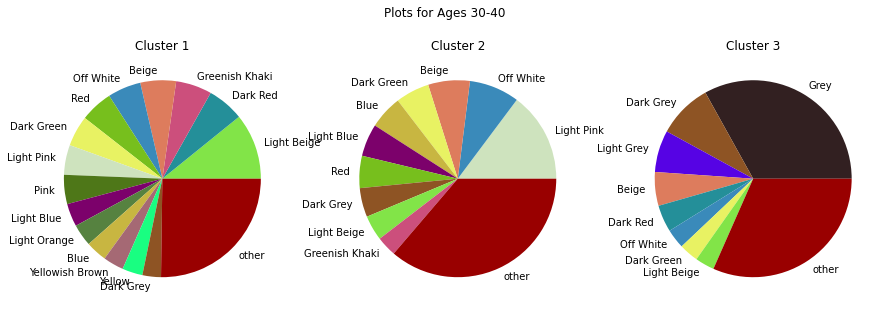

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


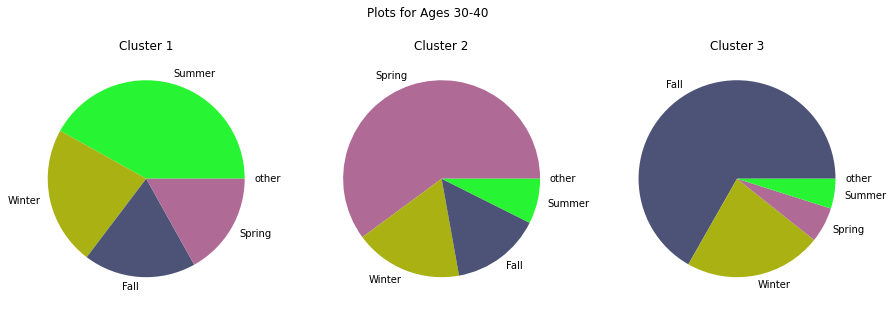

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


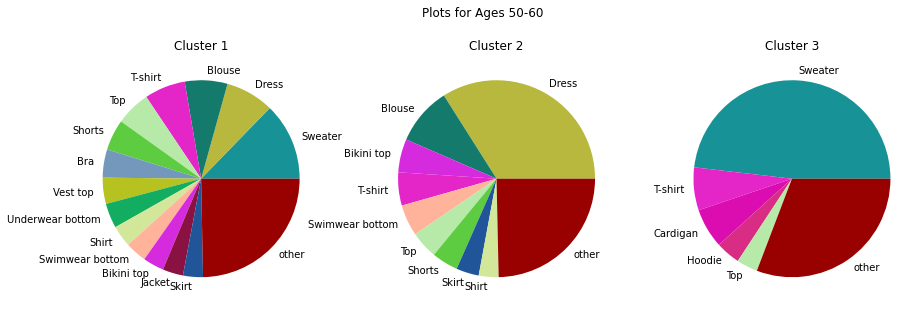

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


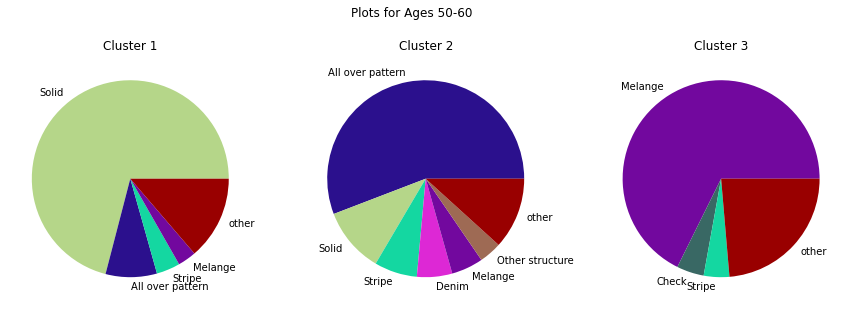

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


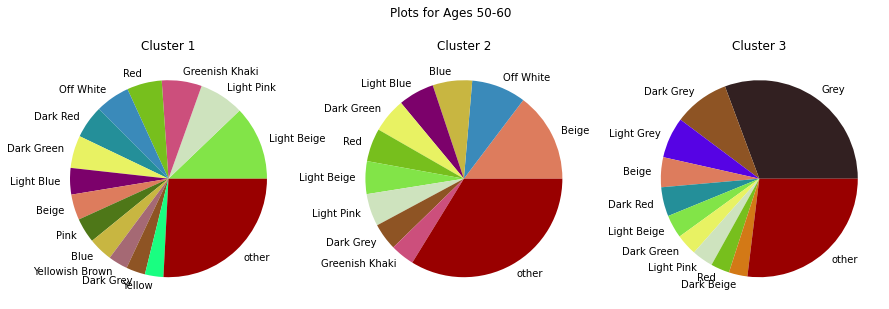

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


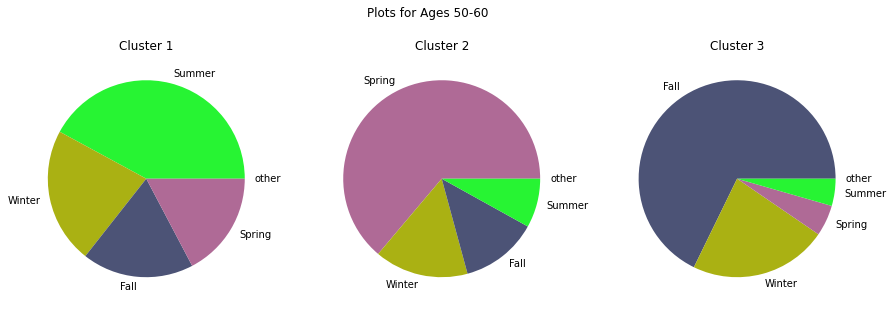

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


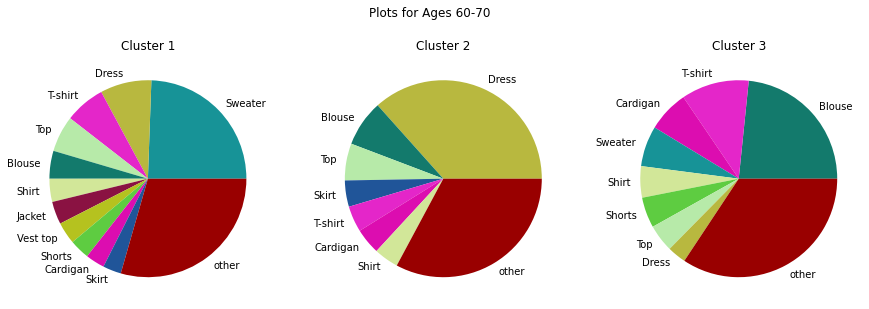

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


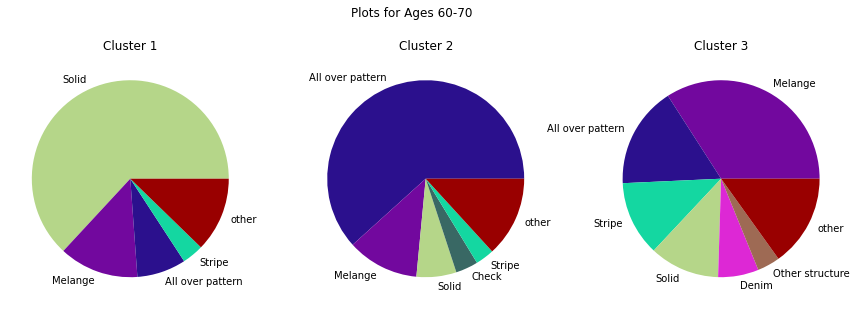

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


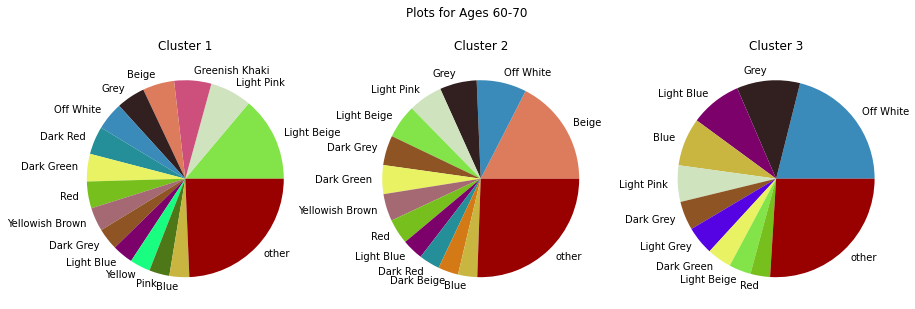

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


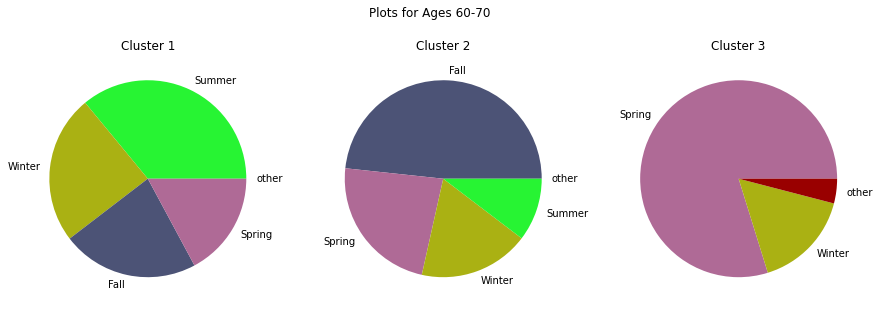

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


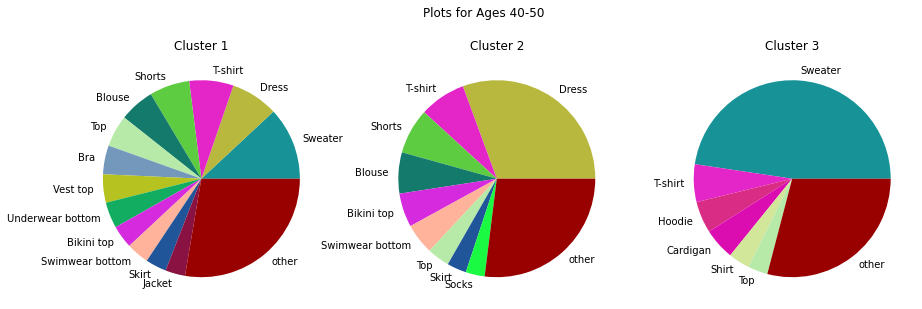

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


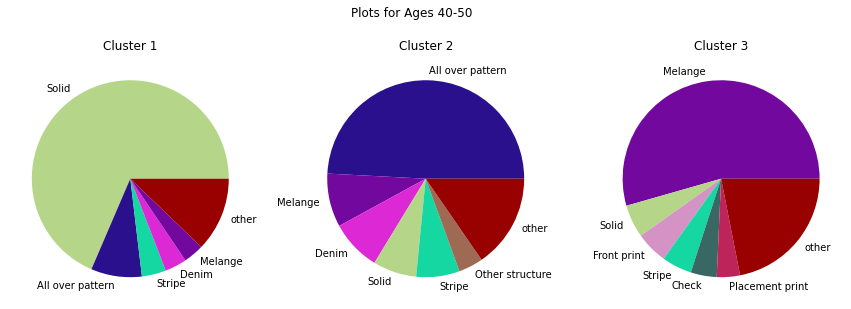

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


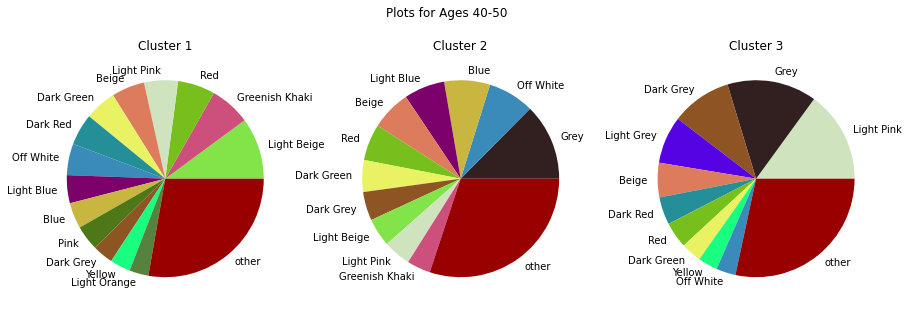

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


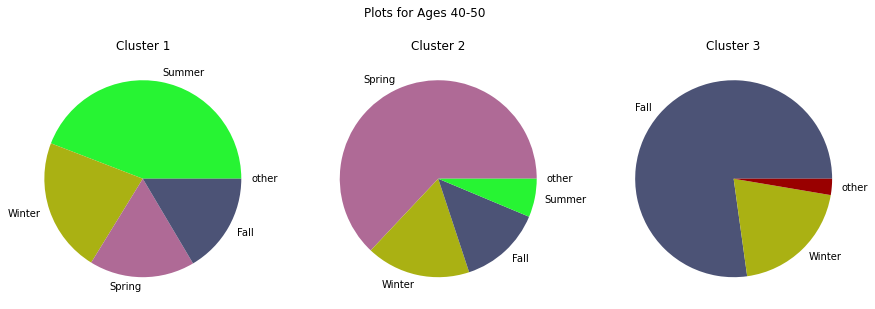

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


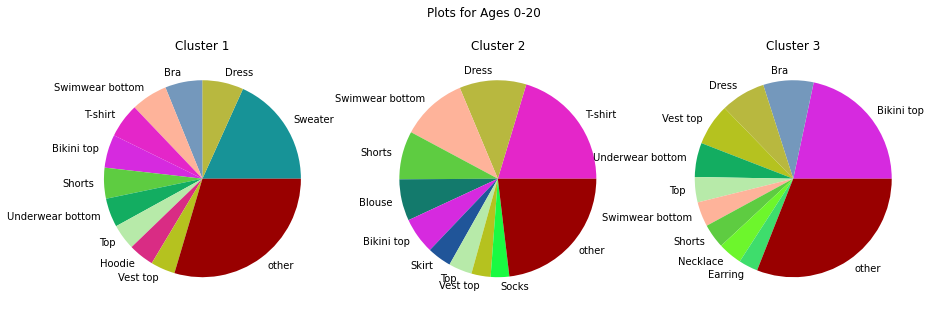

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


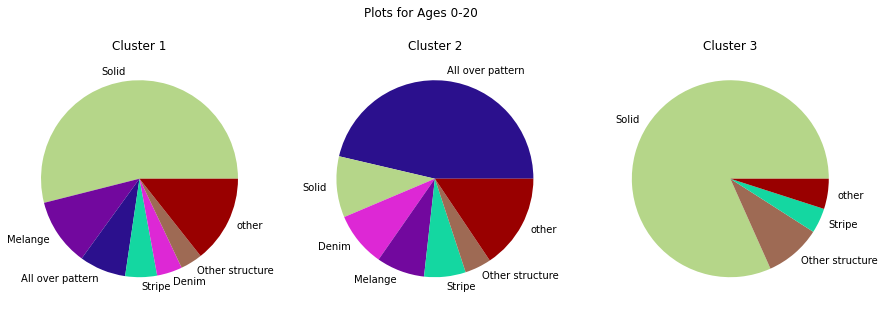

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


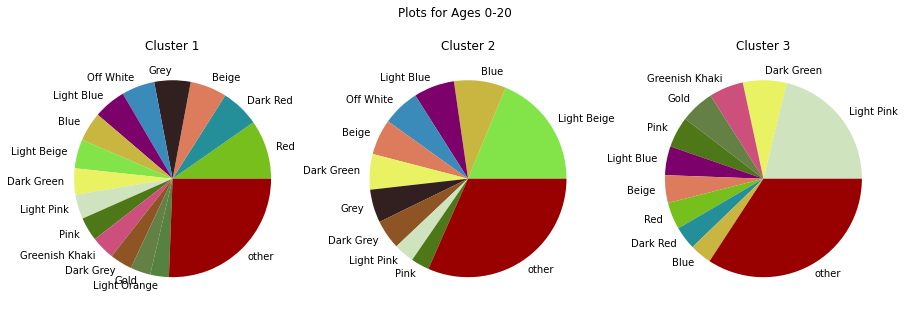

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


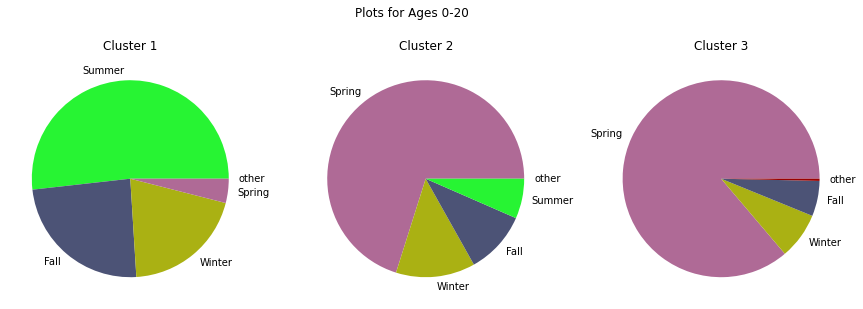

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


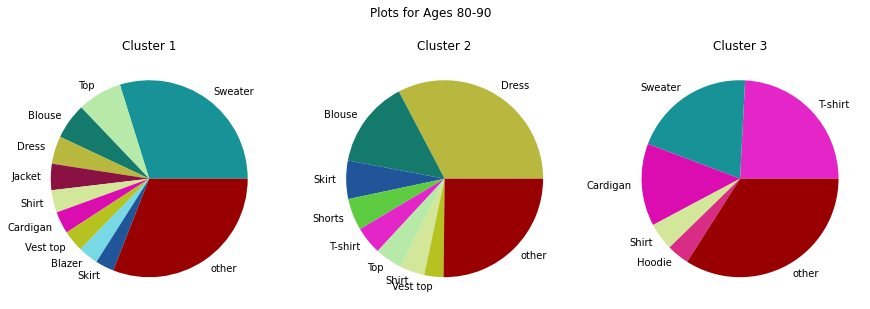

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


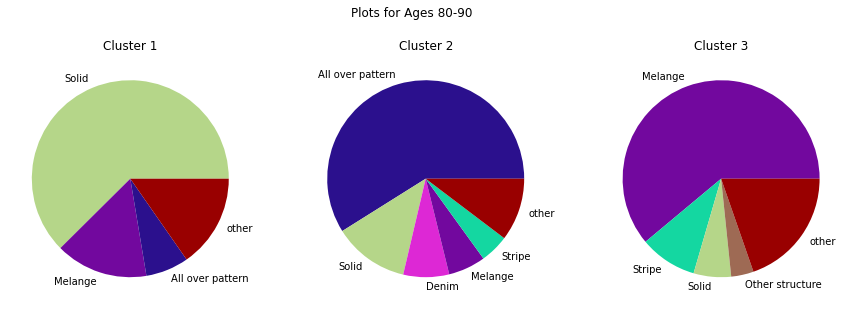

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


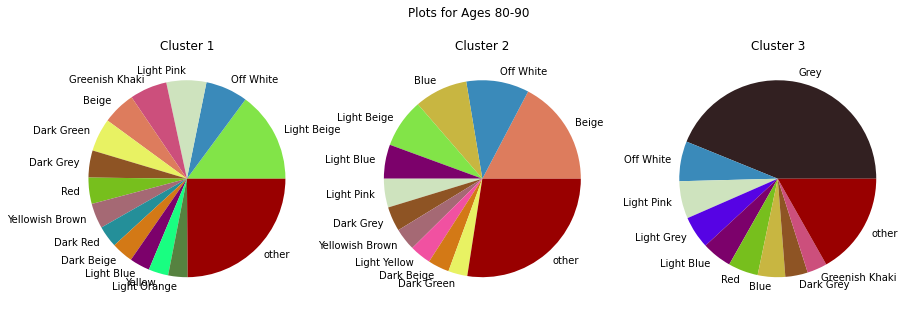

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


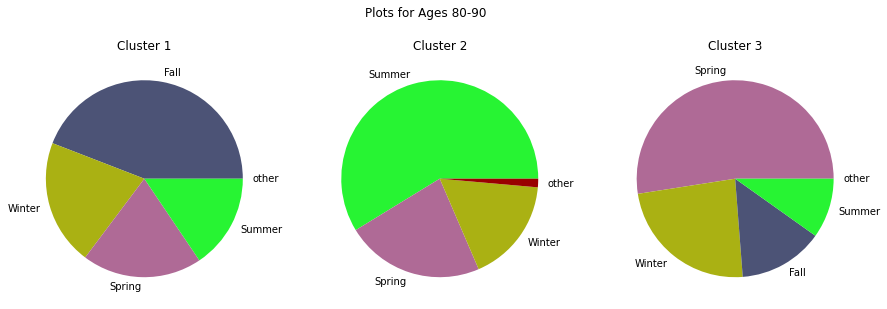

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


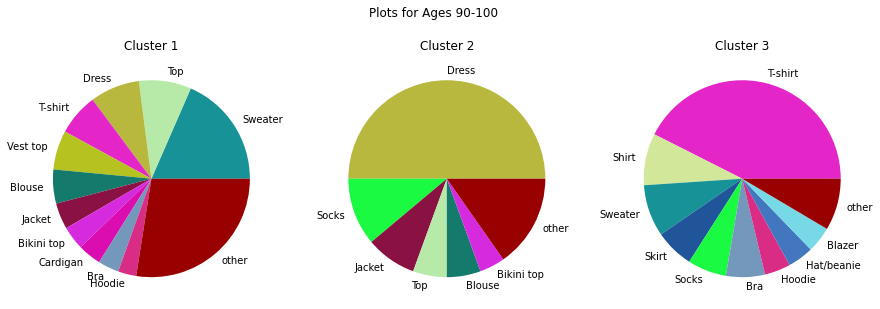

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


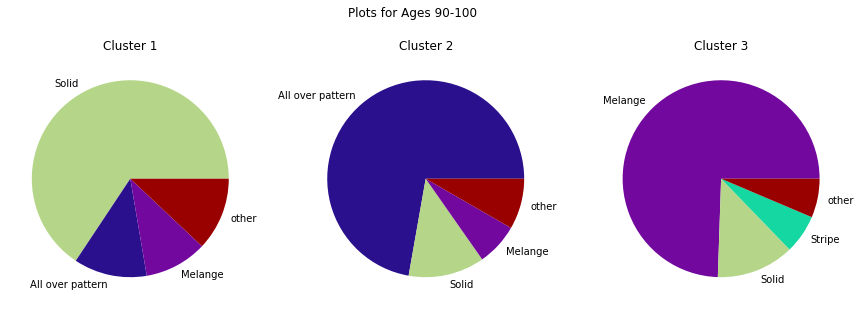

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


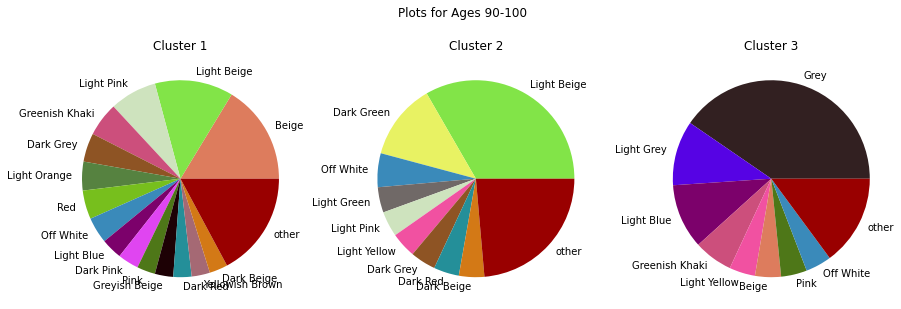

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


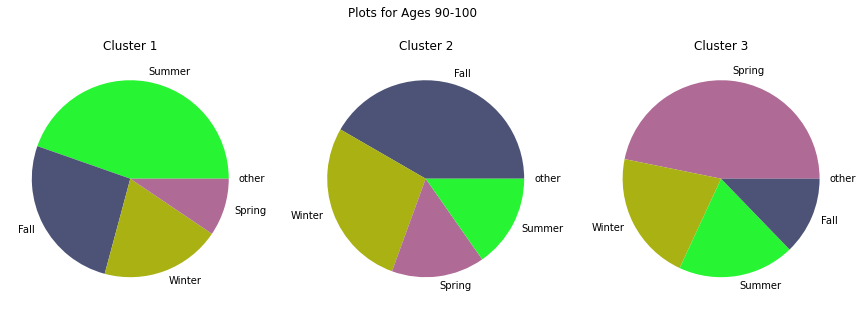

In [16]:
#run for all age groups
for df in df_list:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cat_list, colors_dict=dict_list, foldername = 'test')

In [54]:
df_list_sort = [df_0, df_20, df_30, df_40, df_50, df_60, df_70, df_80, df_90]

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


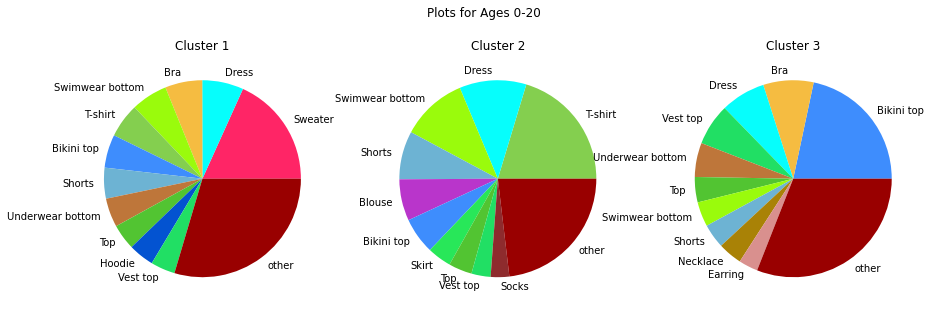

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


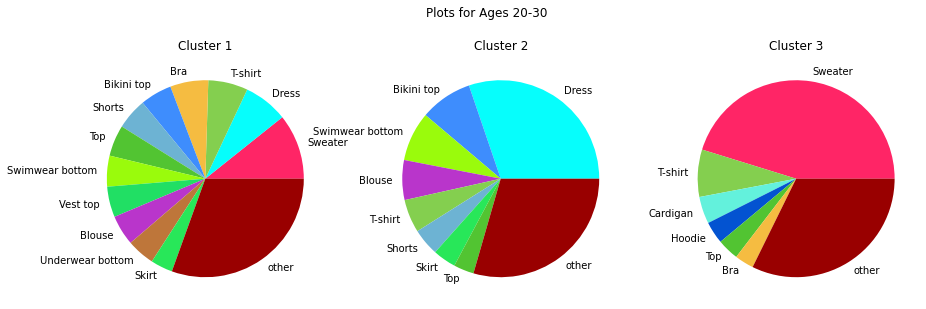

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


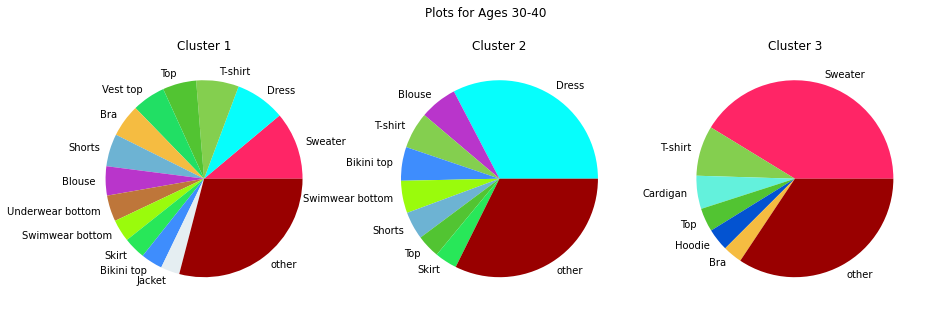

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


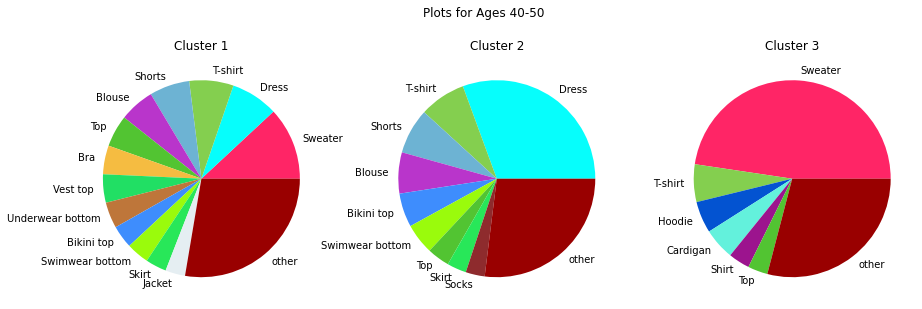

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


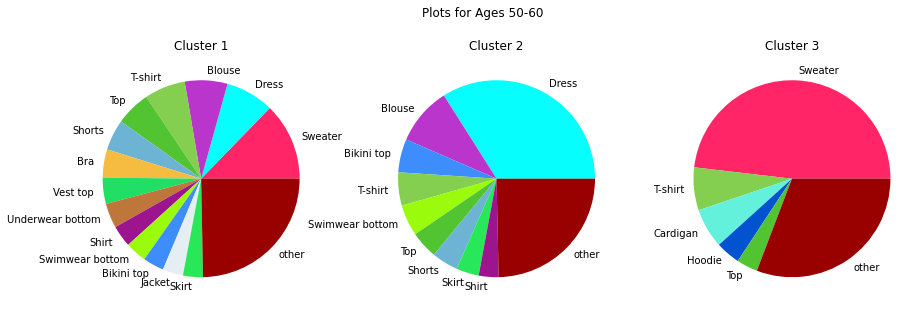

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


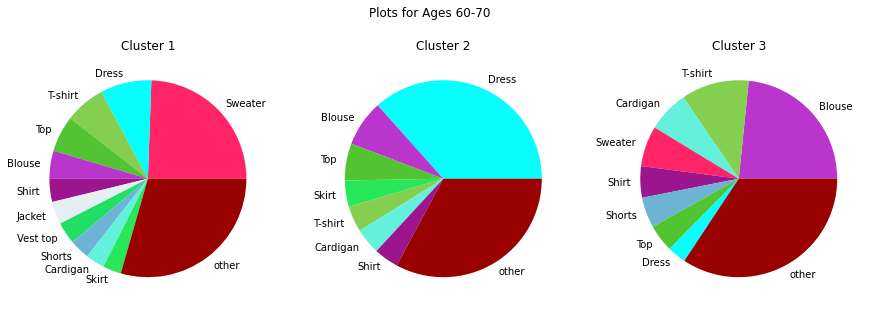

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


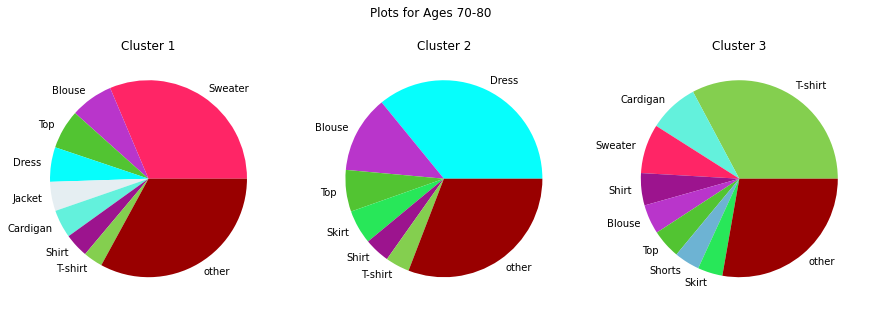

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


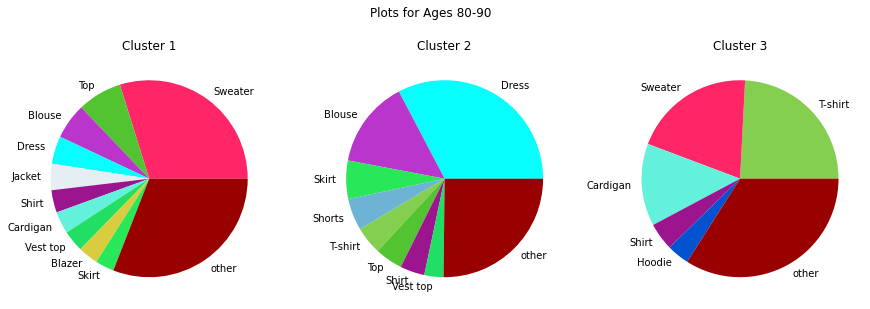

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


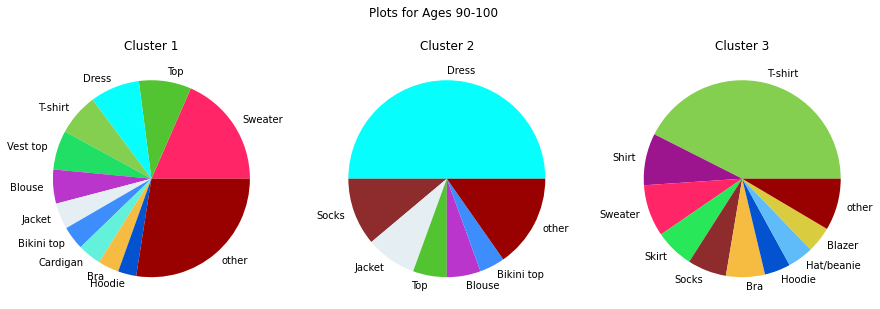

In [57]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#I will copy and paste this cell with all at the end of the notebook

a = 0

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Patterns_Cao_50')

# Considering Cluster sizes 

Look at the (almost even) seasonal breakdown in the data...this is not reflected in the clusters

In [28]:
round(df_0['season'].value_counts(normalize=True),2)

Summer    0.36
Spring    0.27
Fall      0.19
Winter    0.17
Name: season, dtype: float64

In [74]:
round(df_20['season'].value_counts(normalize=True),2)

Summer    0.31
Spring    0.26
Fall      0.23
Winter    0.20
Name: season, dtype: float64

In [75]:
round(df_40['season'].value_counts(normalize=True),2)

Summer    0.29
Spring    0.26
Fall      0.24
Winter    0.21
Name: season, dtype: float64

In [77]:
round(df_70['season'].value_counts(normalize=True),2)

Fall      0.28
Spring    0.24
Summer    0.24
Winter    0.23
Name: season, dtype: float64

In [26]:
total_values = []
prop_values = []
for elem in df_list:
    total_values.append(elem['Cluster'].value_counts())
    prop_values.append(elem['Cluster'].value_counts()/len(elem))

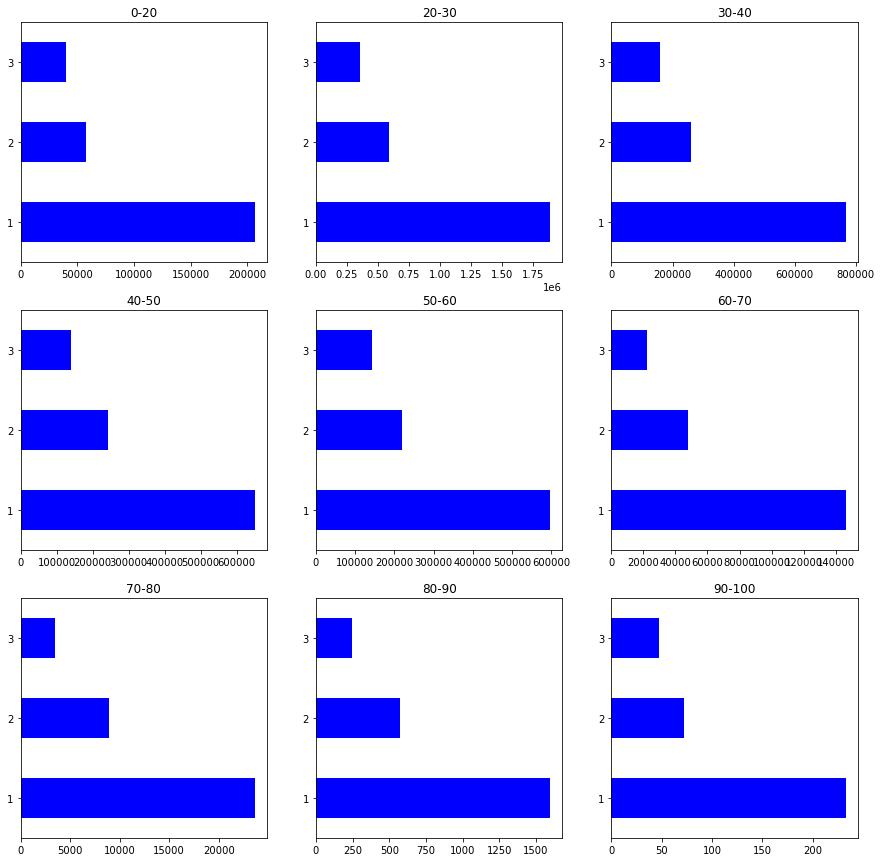

In [50]:
#plot sizes of clusters for each age group

n = 0
plt.figure(figsize=(15, 15))

for elem in df_list_sort: 
    ax = plt.subplot(3, 3, n + 1)
    elem.Cluster.value_counts().sort_index(axis=0).plot(kind = 'barh', ax = ax, color = "blue")
    ax.set_title(elem['age_bin'][1])
    
    n+=1
    
plt.show()

# Discussion (post-Cao initialization)

All of the clusters are roughly equal sizes across age groups, though they do not all represent the same types of clusters. Increasing to four clusters did not result in clusters with four different seasons. Decreasing to two clusters did not show two distinct seasons. (I have these in other notebooks). What can we interpret from this?

----> Almost certainly that people buy varieties throughout the year.

----> Perhaps the clusters show us which seasonal fashion trends are most important to that age group? Because the clusters are representations of many people buying items with things/at times in common?

----> People generally buy more basics in the summer? Or more variety in the summer?

----> People don't care much about fashion in the winter? (never clusters)


I am curious about how frequent item sets aligns with products in clusters 2 and 3 for each age group.

Ages 20-70 very similar seasonality 

Younger groups favor summer, older favor fall (but also converge to pretty equal transactions per season)

I think most clusters can still be classified as <b>Everyday, Season1, Season2, dependent on the age group. For all groups, the first cluster is Everyday and holds about 2/3 of all data.
    
Everyday remains characterized by high variety. 
    
Since Cao initialization, color trends have become more dominant. 
    
It should be noted that Sweaters and Dresses are in the top two highest number of transactions for all age groups (though tied with t-shirt and bikini for the 0-20 group)
    
I am sure there is more!

In [73]:
round(df_0['Cluster'].value_counts(normalize=True),2)

1    0.68
2    0.19
3    0.13
Name: Cluster, dtype: float64

# Misc

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


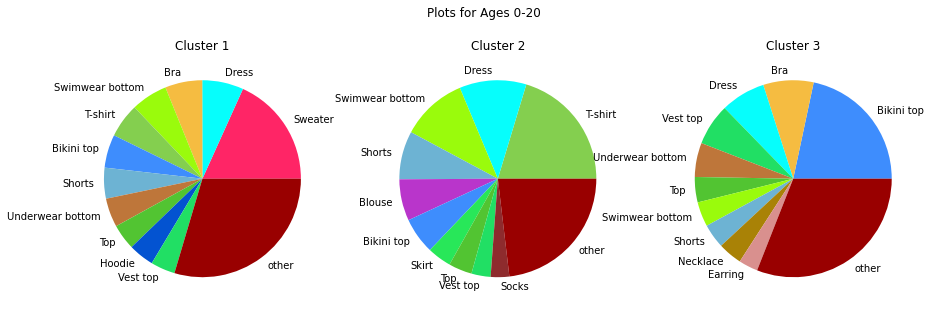

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


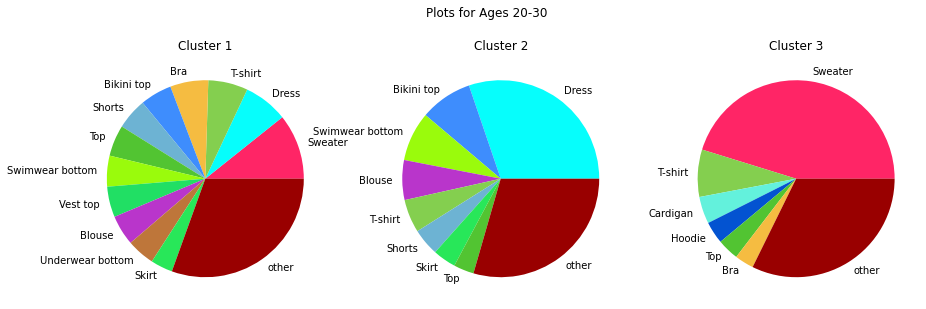

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


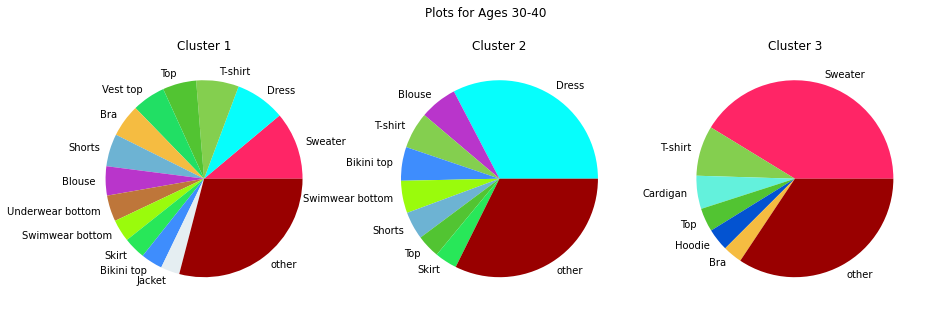

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


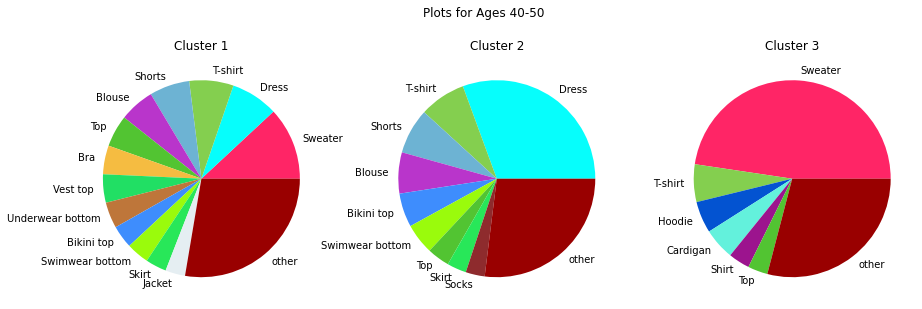

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


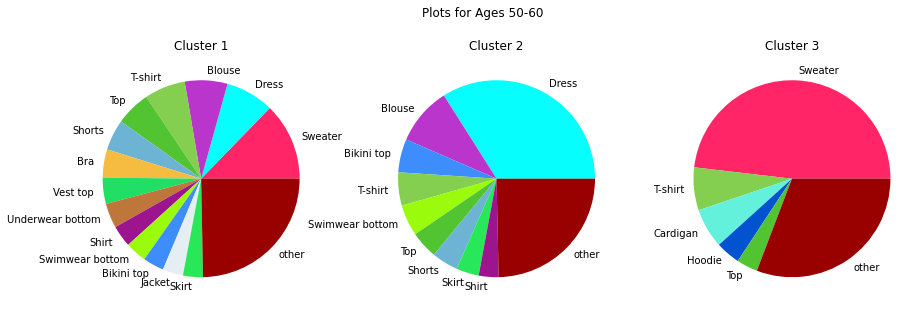

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


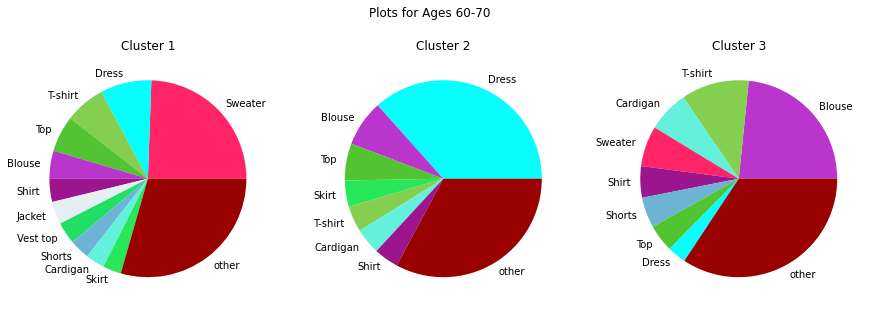

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


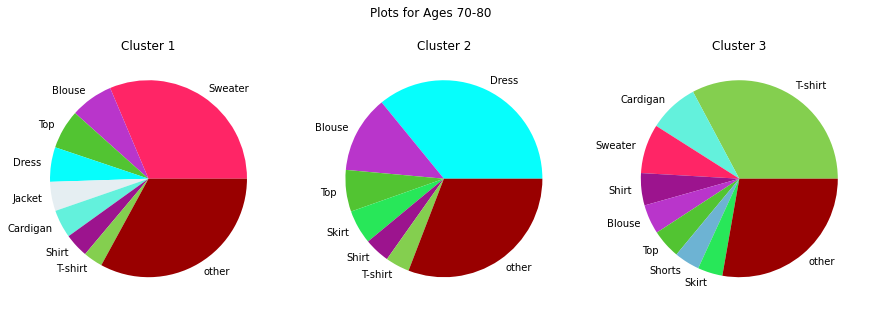

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


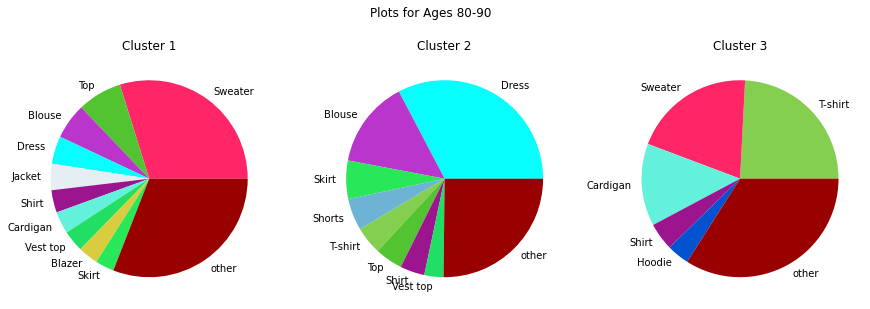

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


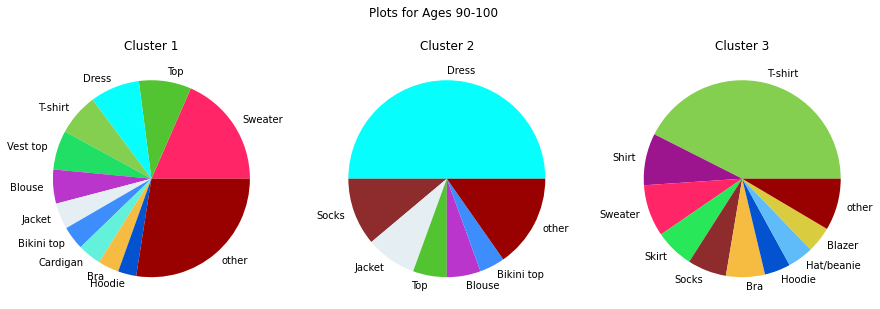

In [58]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 0

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Products_Cao_50')

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


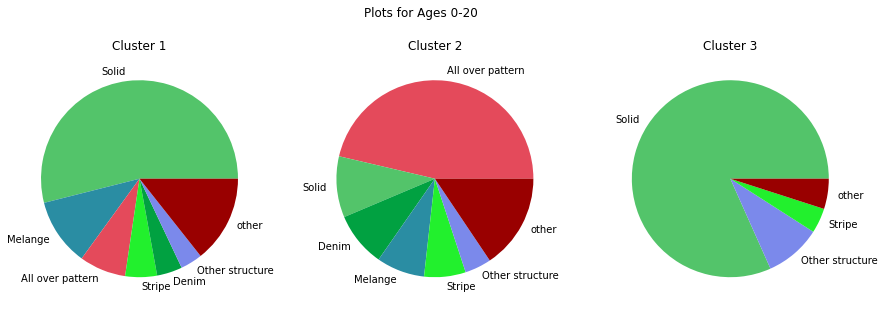

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


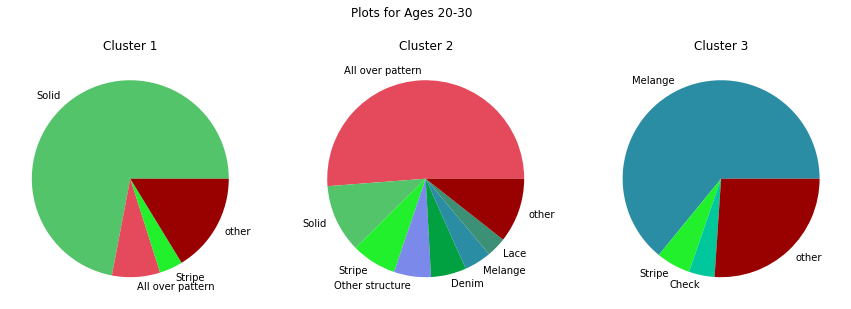

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


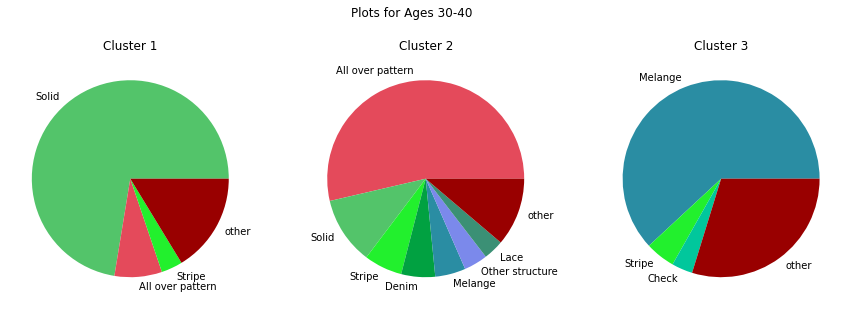

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


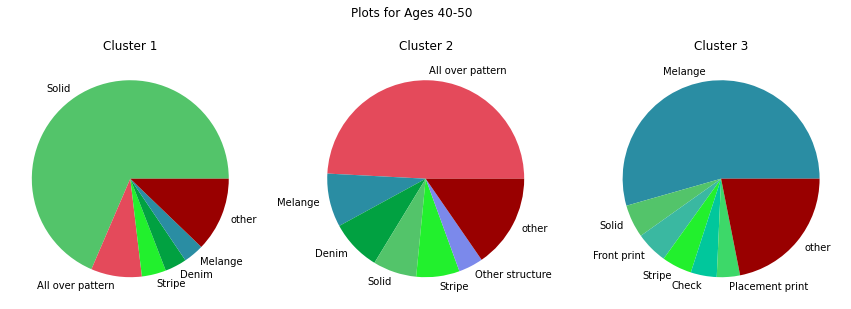

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


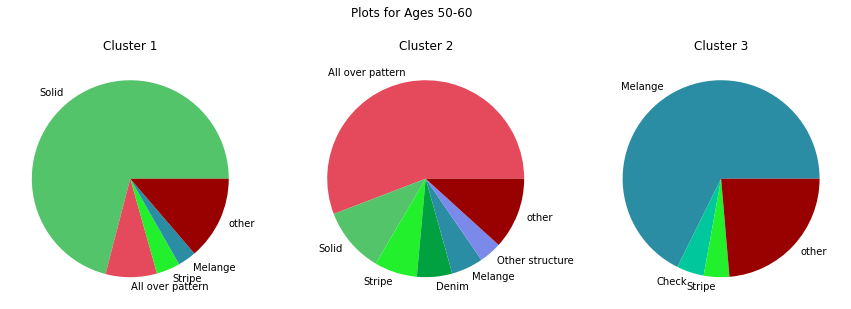

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


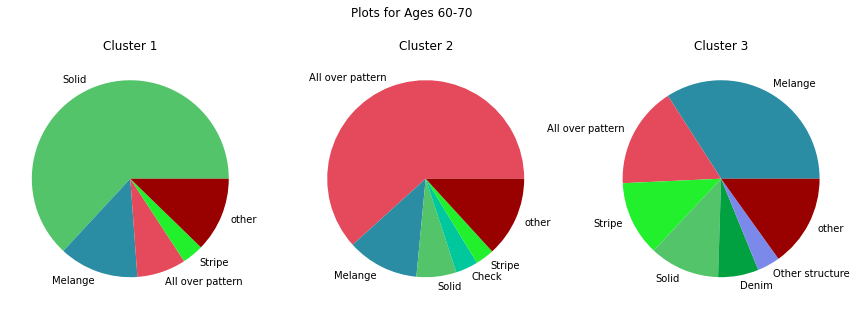

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


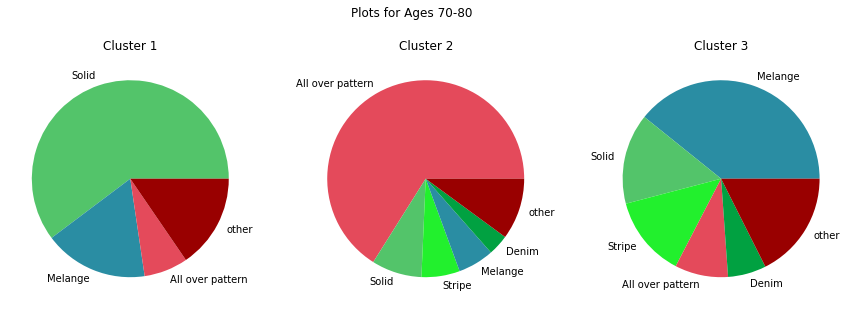

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


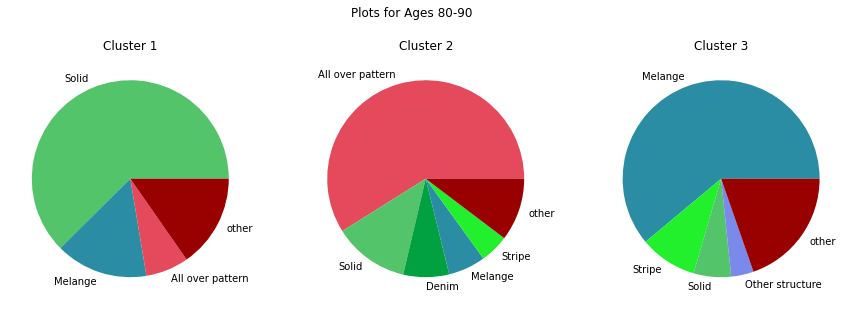

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


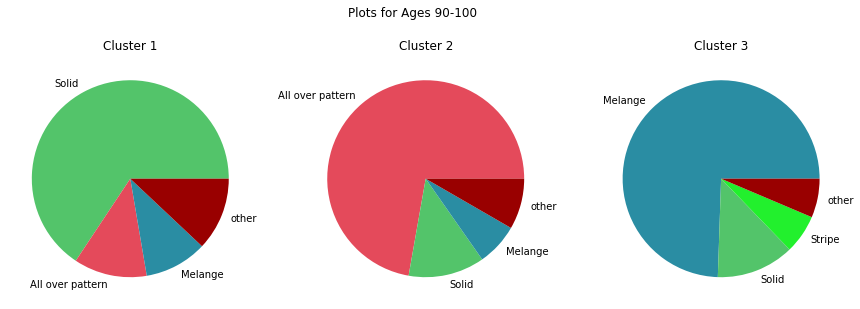

In [59]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 1

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Patterns_Cao_50')

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


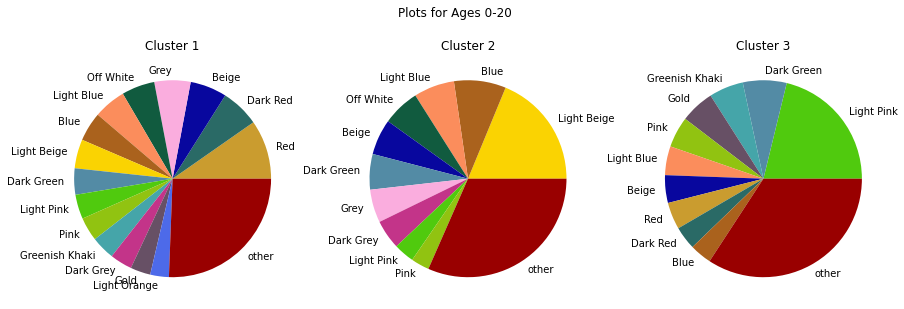

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


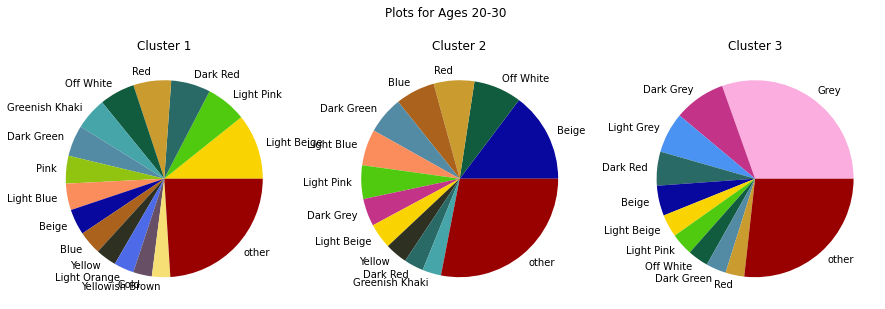

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


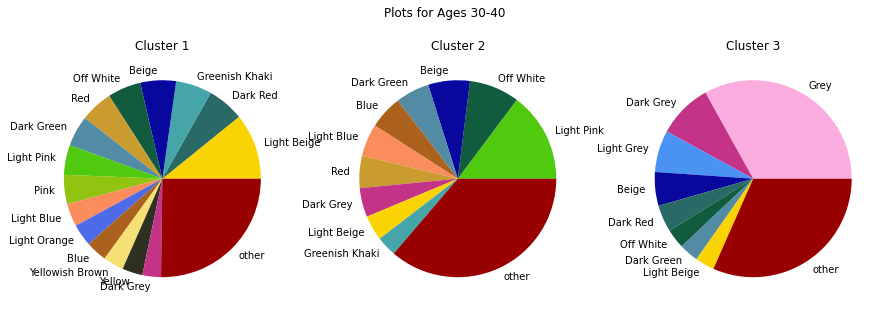

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


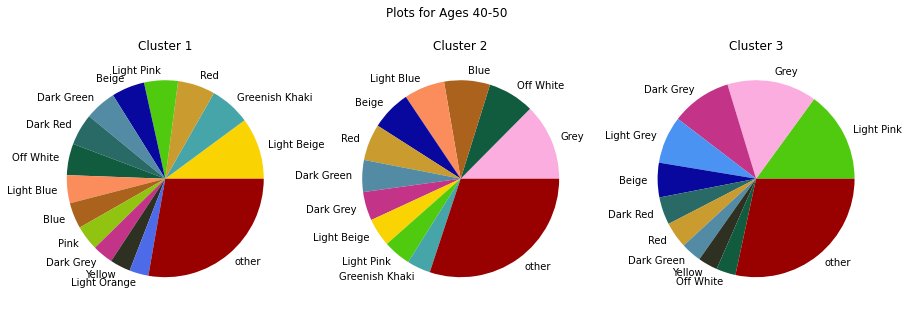

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


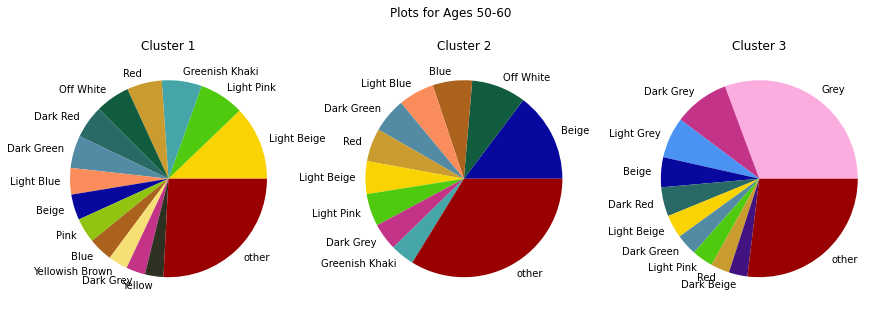

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


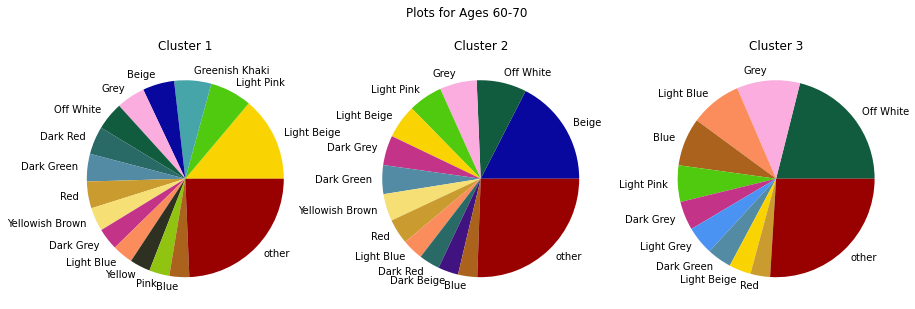

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


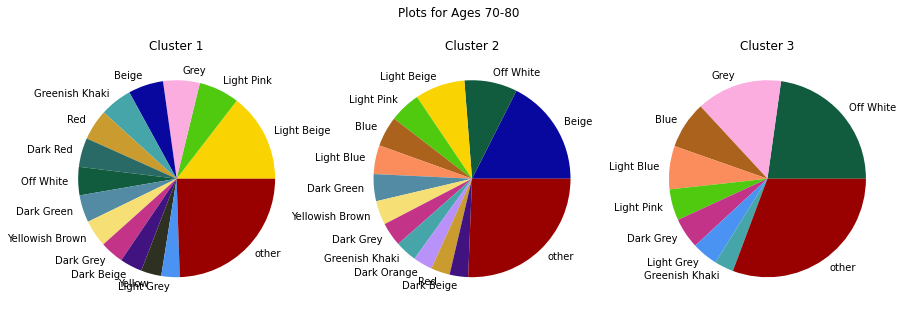

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


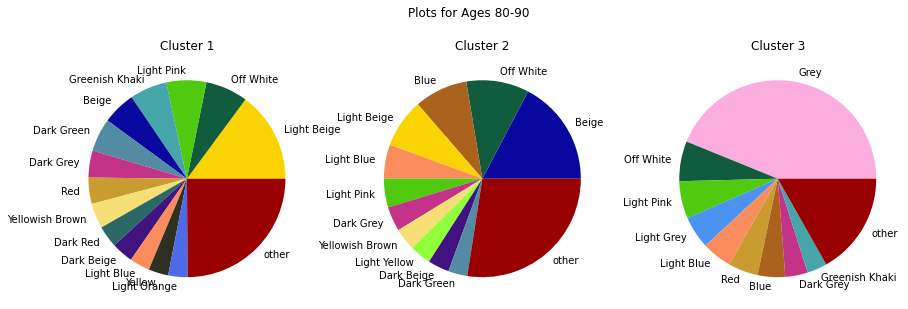

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


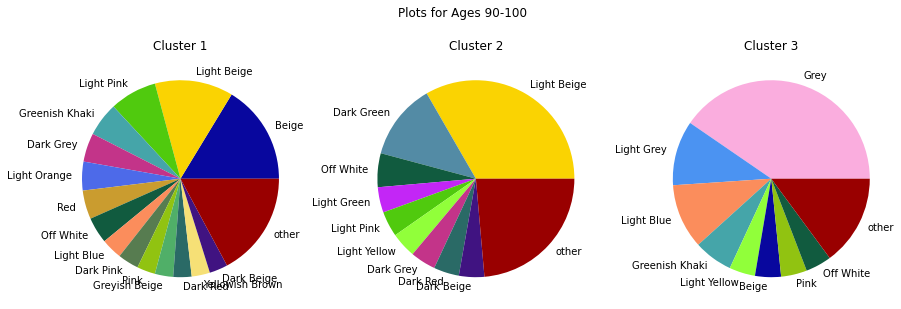

In [60]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 2

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Colors_Cao_50')

n1 =  206720 , n2 =  57847 , n3 =  40267
p1 =  0.678 , p2 =  0.19 , p3 =  0.132


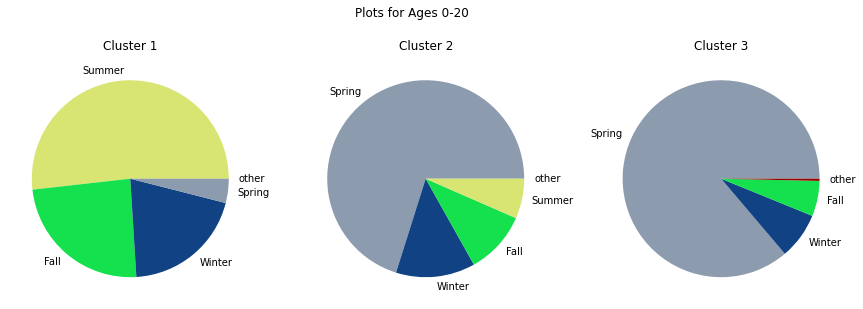

n1 =  1889720 , n2 =  585588 , n3 =  354842
p1 =  0.668 , p2 =  0.207 , p3 =  0.125


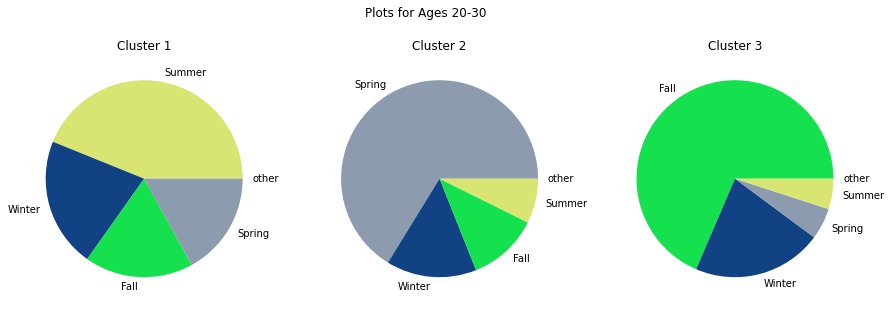

n1 =  766846 , n2 =  259561 , n3 =  160255
p1 =  0.646 , p2 =  0.219 , p3 =  0.135


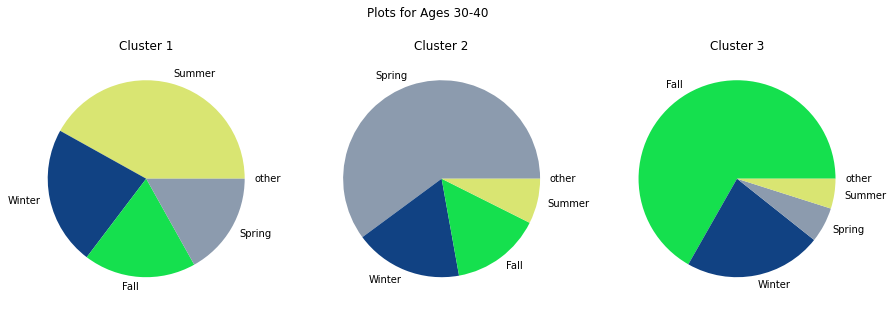

n1 =  650558 , n2 =  241872 , n3 =  140197
p1 =  0.63 , p2 =  0.234 , p3 =  0.136


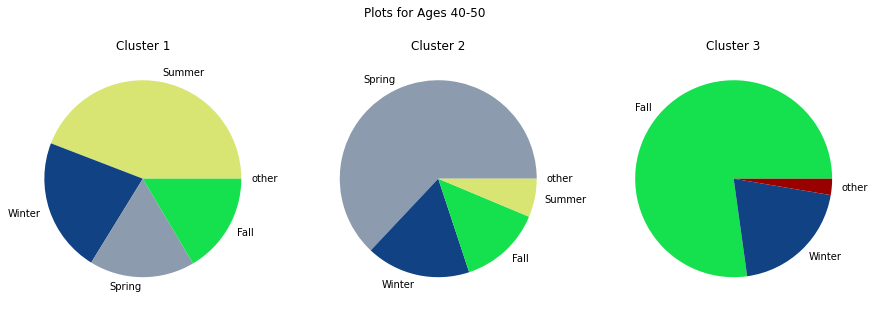

n1 =  597346 , n2 =  218694 , n3 =  142591
p1 =  0.623 , p2 =  0.228 , p3 =  0.149


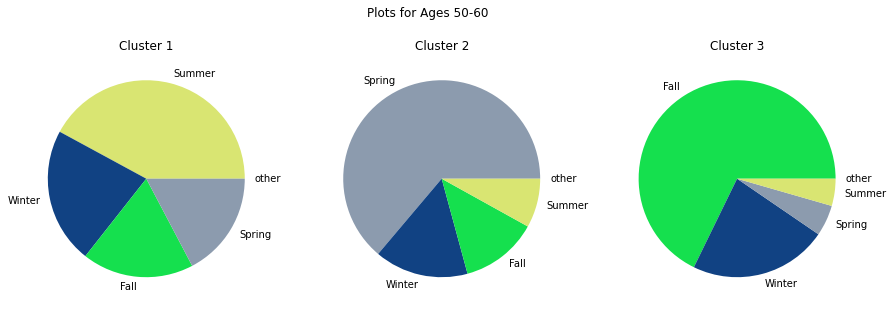

n1 =  146393 , n2 =  47886 , n3 =  22183
p1 =  0.676 , p2 =  0.221 , p3 =  0.102


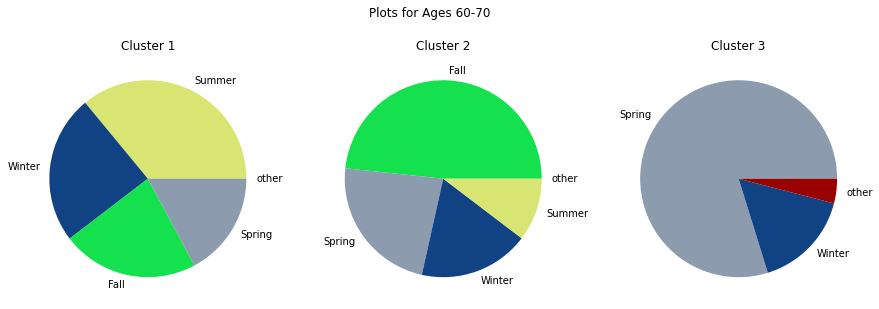

n1 =  23667 , n2 =  8890 , n3 =  3498
p1 =  0.656 , p2 =  0.247 , p3 =  0.097


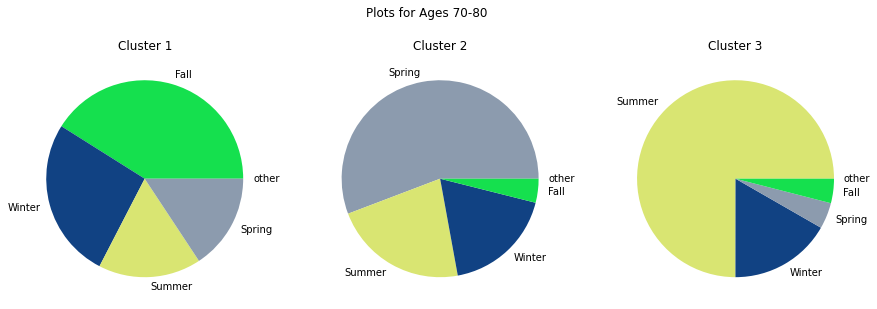

n1 =  1600 , n2 =  572 , n3 =  244
p1 =  0.662 , p2 =  0.237 , p3 =  0.101


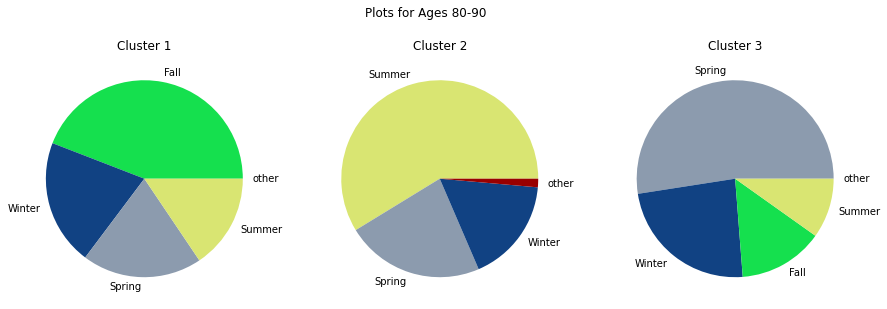

n1 =  233 , n2 =  72 , n3 =  47
p1 =  0.662 , p2 =  0.205 , p3 =  0.134


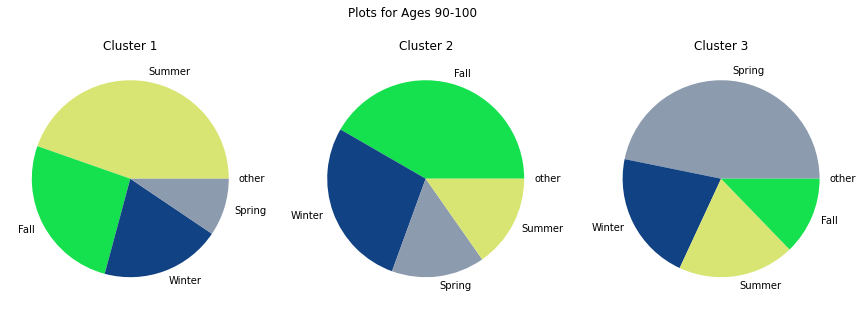

In [61]:
#run for one category only 
#a = 0 = products, 1 = patterns, 2 = colors, 3 = seasons
#COPY AND PASTED

a = 3

patt_list = []
cpatt_list = []

patt_list.append(dict_list[a])
cpatt_list.append(cat_list[a])

for df in df_list_sort:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Seasons_Cao_50')